**Strand breaks** 
TODO NOTES  
Date time incorrect, need a second one to work out new date_time and time taken for calculations, used later speed distance time and whatnot.

In [38]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import yaml
from scipy.special import factorial
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Outputting yaml file containing information on variables and functions used in this notebook.

In [63]:
def open_yaml(yaml_file):
    with open(yaml_file, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

            
def print_yaml(yaml_file):
    yaml_content = open_yaml(yaml_file)
    dictionary = yaml_content
    for key, value in dictionary.items():
        print(key, value)
        
    
yaml_file = 'variable_and_function_names.yaml'
print_yaml(yaml_file)   

Variables 
no_single_strands: Number of single DNA strands

length_strand: Length of DNA strand, this is a measurement of base pairs.

mean_breaks: Average number of breaks per strand.

no_breaks: number of breaks

no_segments: Number of segments generated after proton therapy has been applied and strands have been broken.

length_segment: Length of segments

k: Number of occurrances for poisson function

lam: Poisson function lambda

Functions 
date_time(): Returns date and time programme is run at

poisson_function(k, lam): Determines a poisson distribution from k number of occurrances and lam lambda, this is called in data_visualisation()

data_visualisation(mean_breaks, length_strand, length_segment): Data visualisation of number of breaks of dna strands and segment lengths



**Develop simulation of strand length**  
Choose the actual number of breaks for a given strand using a Poisson distribution and the mean number of breaks per strand. Assume the breaks are uniformly distributed along each strand. Calculate the distance between breaks (the segment lengths) by sorting the breaks according to distance along the strand then subtracting successive break positions. Add the first and and last segment lengths (zero to first sorted break, last sorted break to strand length, respectively).  
**Questions to discuss at next meeting**  
Why are we using date time? Why do we need to work out now-then in final part?  
Why are we using length_strand for segment length histogram?

Date and time  2022-11-15 15:39:09.654590
 
Date and time 2022-11-15 15:39:09.654590
Time since last check is 0:00:00


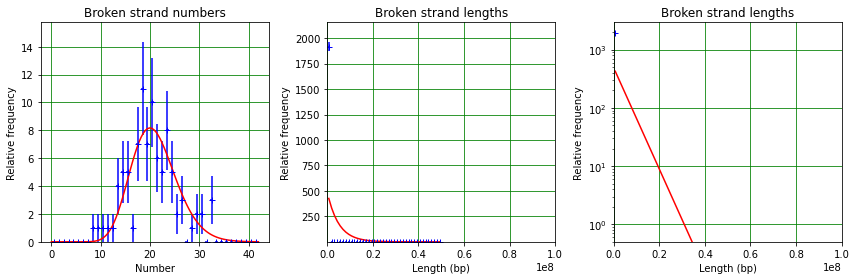

In [50]:
def define_variables():
    '''
    Defining variables used in later functions. Please see yaml file for further information about variables.
    '''
    no_single_strands = 92
    length_strand = 1e8 
    mean_breaks = 20 
    no_segments = np.zeros(no_single_strands).astype(int)
    length_segment = np.zeros((no_single_strands, (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)))

    
def date_time():
    '''
    date time function
    Parameters:
    Returns:
    '''
    # why are we importing date time?
    now = datetime.datetime.now()
    print("Date and time ",str(now))
    then = now
    now = datetime.datetime.now()
    print(" ")
    print("Date and time",str(now))
    print("Time since last check is",str(now - then))


def poisson_function(k, lam):
    '''
    Poisson distribution function.
    Parameters: k number of occurances, lam lambda of the poisson function.
    Returns: distribution function value.
    '''
    poisson = lam**k*np.exp(-lam)/sp.special.factorial(k)
    return poisson


def data_visualisation(mean_breaks, length_strand, length_segment):
    '''
    Parameters: mean_breaks used to display number of breaks, 
                length_strand used for segment length histogram,
                length_segment used for 
    Returns: two histograms displaying the number of breaks and segment lengths
    '''
    # Set up histogram of number of breaks
    num_range = np.zeros(2)
    num_range[0] = np.maximum(mean_breaks - 5*np.sqrt(mean_breaks), 0.0).astype(int)
    num_range[1] = (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)
    n_num_bins = ((num_range[1] - num_range[0])).astype(int)
    num_bins, num_bin_wid = np.linspace(num_range[0], num_range[1], n_num_bins + 1, retstep = True)
    num_bin_cents = 0.5*(num_bins[0:n_num_bins] + num_bins[1:n_num_bins + 1])
    num_bin_err = num_bin_wid/np.sqrt(12)*np.ones(n_num_bins)
    cum_num_hist = np.zeros(n_num_bins)

    # Set up histogram of segment lengths
    n_len_bins = 40
    len_bins, len_bin_wid = np.linspace(0.0, 10*length_strand/mean_breaks, n_len_bins + 1, retstep = True)
    len_bin_cents = 0.5*(len_bins[0:n_len_bins] + len_bins[1:n_len_bins + 1])
    len_bin_err = len_bin_wid/np.sqrt(12)*np.ones(n_len_bins)
    cum_len_hist = np.zeros(n_len_bins)
    
    
    rng = np.random.default_rng()
    
    # Simulate breaks and segments for all strands
    for n in range(0, no_single_strands):
        no_breaks = rng.poisson(mean_breaks)
        breaks = np.zeros(no_breaks)
        no_segments[n] = no_breaks + 1
        breaks = rng.uniform(0.0, 1.0, no_breaks)
        ends = np.zeros(no_segments[n] + 1)
        ends[1:no_segments[n]] = np.sort(breaks)
        ends[no_segments[n]] = 1.0
        segment_lengths[n, 0:no_segments[n]] = length_strand*(ends[1:no_segments[n] + 1] - ends[0:no_segments[n]])    
        
        num_hist_here, _ = np.histogram(no_breaks, num_bins)
        cum_num_hist += num_hist_here 
        
        len_hist_here, _ = np.histogram(length_segment[n, 0:no_segments[n]], len_bins)
        cum_len_hist += len_hist_here
    
    n_poiss_plot = 100
    k_poiss_plot = np.linspace(num_range[0], num_range[1], n_poiss_plot)
    poiss_func_plot = no_single_strands*num_bin_wid*poisson_function(mean_breaks, k_poiss_plot)

    # Function describing segment length distribution
    len_func_plot = (mean_breaks*(mean_breaks + 1)*no_single_strands*
                    len_bin_wid/length_strand*np.exp(-mean_breaks*len_bin_cents/length_strand))

    fig, ax = plt.subplots(1, 3, figsize = (12, 4))

    ax[0].set_title('Broken strand numbers')
    ax[0].errorbar(num_bin_cents, cum_num_hist, xerr = num_bin_err, yerr = np.sqrt(cum_num_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[0].plot(k_poiss_plot, poiss_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[0].set_xlabel('Number')
    ax[0].set_ylabel('Relative frequency')
    ax[0].set_ylim(0.0, 1.1*(np.amax(cum_num_hist) + np.amax(np.sqrt(cum_num_hist))))
    ax[0].grid(color = 'g')

    ax[1].set_title('Broken strand lengths')
    ax[1].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[1].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[1].set_xlabel('Length (bp)')
    ax[1].set_ylabel('Relative frequency')
    ax[1].set_xlim(0.0, length_strand)
    ax[1].set_ylim(0.5, 1.1*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
    ax[1].grid(color = 'g')

    ax[2].set_title('Broken strand lengths')
    ax[2].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[2].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[2].set_xlabel('Length (bp)')
    ax[2].set_ylabel('Relative frequency')
    ax[2].set_xlim(0.0, length_strand)
    ax[2].set_ylim(0.5, 1.5*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
    ax[2].set_yscale('log')
    ax[2].grid(color = 'g')

    plt.tight_layout()
    plt.show


define_variables()
date_time()
data_visualisation(mean_breaks, length_strand, length_segment)



**DNA clumping**  
Chromosomes are coiled up into roughly spherical structures when not undergoing mitosis. The typical diameter of the sphere is about 3 to 4 \mum. Put one end of each strand inside a sphere of radius 2 \mum. (The breaks are assumed not to influence this intial structure!) Nuclear diameter about 20 \mum. See here for information on mouse nucleus!.


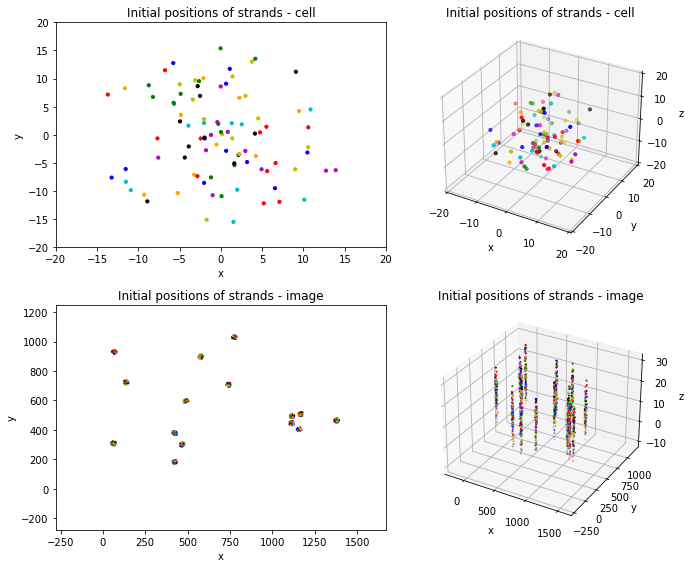

In [48]:

use_sphere = True

# Radius of nucleus microns
rad_nuc = 2.0 
rad_nuc_min = 1.5 
sig_rad_nuc = 0.5 

# Radius of cell microns
rad_cell = 10.0 # microns
rad_cell_min = 16.0 # microns
sig_rad_cell = 1.0 # microns

# Color table for plots
n_color_tab = 8
color_tab = np.array(['r', 'orange', 'y', 'g', 'c', 'b', 'm', 'k'])

fig = plt.figure(figsize = (10, 8))
#
ax2d_cell = fig.add_subplot(2, 2, 1)
ax2d_cell.set_title("Initial positions of strands - cell")
ax2d_cell.set_xlabel("x")
ax2d_cell.set_ylabel("y")
#
ax3d_cell = fig.add_subplot(2, 2, 2, projection='3d')
ax3d_cell.set_title("Initial positions of strands - cell")
ax3d_cell.set_xlabel("x")
ax3d_cell.set_ylabel("y")
ax3d_cell.set_zlabel("z")
#
ax2d_pic = fig.add_subplot(2, 2, 3)
ax2d_pic.set_title("Initial positions of strands - image")
ax2d_pic.set_xlabel("x")
ax2d_pic.set_ylabel("y")
#
ax3d_pic = fig.add_subplot(2, 2, 4, projection='3d')
ax3d_pic.set_title("Initial positions of strands - image")
ax3d_pic.set_xlabel("x")
ax3d_pic.set_ylabel("y")
ax3d_pic.set_zlabel("z")
#
# Image dimensions
n_rows = 1040 # number of rows of pixels (y coord)
n_cols = 1392 # number of columns of pixels (x coord)
depth = 20
#
# Set up number of cells and their positions
n_cells = 15
x_cell = np.zeros(n_cells)
y_cell = np.zeros(n_cells)
z_cell = np.zeros(n_cells)
#
# Set location of cells
if n_cells == 1:
    x_cell[0] = n_cols/2
    y_cell[0] = n_rows/2
    z_cell[0] = depth/2
else:
    x_cell = np.random.uniform(0, n_cols, n_cells)
    y_cell = np.random.uniform(0, n_rows, n_cells)
    z_cell = np.random.uniform(0, depth, n_cells)

#
# Colors for plotting strands
colors = np.zeros(n_strands).astype(str)
#
for n_cell in range(0, n_cells):
    #
    # Simulate uniform radial and phi initial distribution of strands
    rad_arr = np.sqrt(np.random.uniform(0, max(np.random.normal(rad_cell, sig_rad_cell, 1),
                                              rad_cell_min)**2, n_strands))
    phi_arr = np.random.uniform(0, 2*np.pi, n_strands)
    #
    # Determine initial coordinates of strands (simulate uniform intial theta distribution if required)
    if use_sphere:
        theta_arr = np.arccos(np.random.uniform(-1, 1, n_strands))
        x_arr = x_cell[n_cell] + rad_arr*np.sin(theta_arr)*np.cos(phi_arr)
        y_arr = y_cell[n_cell] + rad_arr*np.sin(theta_arr)*np.sin(phi_arr)
        z_arr = z_cell[n_cell] + rad_arr*np.cos(theta_arr)
    else:
        x_arr = x_cell[n_cell] + rad_arr*np.cos(phi_arr)
        y_arr = y_cell[n_cell] + rad_arr*np.sin(phi_arr)
        z_arr = x_cell[n_cell] + np.random.uniform(0, depth, n_strands)
    #
    # Plot intial positions of all strands in image
    col_inds = (np.linspace(0, n_strands - 1, n_strands)%n_color_tab).astype(int)
    ax2d_pic.scatter(x_arr, y_arr, color = color_tab[col_inds], s = 1.0)
    ax3d_pic.scatter(x_arr, y_arr, z_arr, color = color_tab[col_inds], s = 1.0)
    #
    if n_cell > 0:
        continue
    #
    # Plot initial positions of strands in one cell 
    ax2d_cell.scatter(x_arr - x_cell[n_cell], y_arr - y_cell[n_cell], color = color_tab[col_inds], s = 10.0)
    ax3d_cell.scatter(x_arr - x_cell[n_cell], y_arr - y_cell[n_cell], 
                      z_arr - z_cell[n_cell], color = color_tab[col_inds], s = 10.0)    
#
scale_cell = 2.0
ax2d_cell.set_xlim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax2d_cell.set_ylim(-scale_cell*rad_cell, scale_cell*rad_cell)
#
ax3d_cell.set_xlim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax3d_cell.set_ylim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax3d_cell.set_zlim(-scale_cell*rad_cell, scale_cell*rad_cell)
#
expand_pic = 0.2
ax2d_pic.set_xlim(-expand_pic*n_cols, (1 + expand_pic)*n_cols)
ax2d_pic.set_ylim(-expand_pic*n_cols, (1 + expand_pic)*n_rows)
#
ax3d_pic.set_xlim(-expand_pic*n_cols, (1 + expand_pic)*n_cols)
ax3d_pic.set_ylim(-expand_pic*n_cols, (1 + expand_pic)*n_rows)
ax3d_pic.set_zlim(-(1 + expand_pic)*rad_cell, depth + (1 + expand_pic)*rad_cell)
#
plt.tight_layout()
plt.show()

**Motion of DNA in Agrose**  

Date and time  2022-11-15 15:57:28.485473
 
Date and time 2022-11-15 15:57:28.485473
Time since last check is 0:00:00
 
Parameters used to descibe vD in agarose
kB = 2.24
kC = 0.56
kL = 0.59
alpha = 1.34


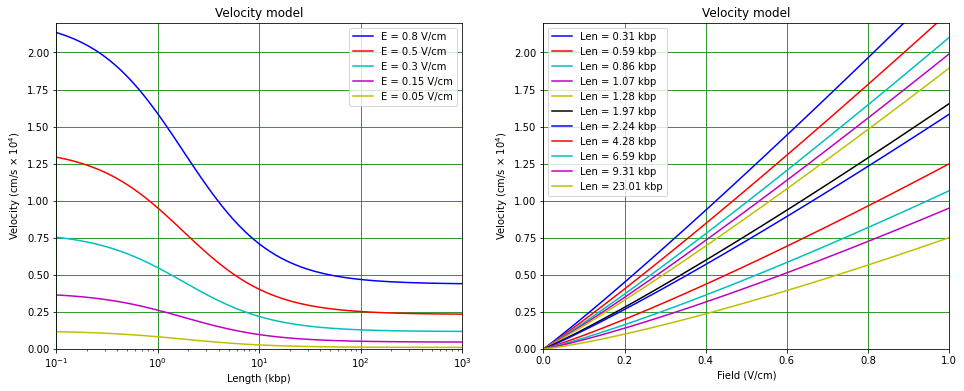

Date and time  2022-11-15 15:57:28.884431
 
Date and time 2022-11-15 15:57:28.884431
Time since last check is 0:00:00


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [67]:
then = date_time()
then
#

#
def vDagarose(L, E):
    '''
    Given length of DNA strand (in kbp) and electric field (in V/cm) returns 
    velocity in agarose (in cm/s * 10^4 or equivalently microns/s).
    '''
    if not hasattr(vDagarose, "kB"):
        vDagarose.kB, vDagarose.kC, vDagarose.kL, vDagarose.alpha = 2.24, 0.56, 0.59, 1.34
        print(" ")
        print("Parameters used to descibe vD in agarose")
        print("kB = {:.2f}".format(vDagarose.kB))
        print("kC = {:.2f}".format(vDagarose.kC))
        print("kL = {:.2f}".format(vDagarose.kL))
        print("alpha = {:.2f}".format(vDagarose.alpha))
    #
    vD = vDagarose.kB*E/(1 + vDagarose.kC*L) + vDagarose.kL*E**vDagarose.alpha
    #
    return vD
#
# Calculate fitted function values x direction
nPlot = 100
xBot = 0.1
xTop = 1000.0
xPlot = np.exp(np.linspace(np.log(xBot), np.log(xTop), nPlot))
nY = 5
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8]) # V/cm
#
# Calculate fitted function values y direction
yBot = 0.0
yTop = 1.0
yPlot = np.linspace(yBot, yTop, nPlot)
nX = 11
xVals = np.array([0.31, 0.59, 0.86, 1.07, 1.28, 1.97, 2.24, 4.28, 6.59, 9.31, 23.01]) # kbp
#
# Plot data
nColTab = 6
colTab = ['b', 'r', 'c', 'm', 'y', 'k']
#
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Velocity model')
ax.set_xlabel('Length (kbp)')
ax.set_ylabel('Velocity (cm/s $\\times$ $10^4$)')
nCol = 0
for plot in range(nY, 0, -1):
    fitPlotX = vDagarose(xPlot, yVals[plot - 1]*np.ones(nPlot))
    ax.plot(xPlot, fitPlotX, linestyle = '-', color = colTab[nCol], label = "E = " + str(yVals[plot - 1]) + " V/cm")
    nCol += 1
    if nCol > nColTab - 1:
        nCol = 0
ax.set_xlim(xBot, xTop)
ax.set_ylim(0, 2.2)
ax.set_xscale('log')
ax.grid(color = 'g')
ax.legend()    
#   
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Velocity model')
ax.set_xlabel('Field (V/cm)')
ax.set_ylabel('Velocity (cm/s $\\times$ $10^4$)')
nCol = 0
for plot in range(0, nX):
    fitPlotY = vDagarose(xVals[plot]*np.ones(nPlot), yPlot)
    ax.plot(yPlot, fitPlotY, linestyle = '-', color = colTab[nCol], label = "Len = " + str(xVals[plot]) + " kbp")
    nCol += 1
    if nCol > nColTab - 1:
        nCol = 0
ax.set_xlim(yBot, yTop)
ax.set_ylim(0, 2.2)
ax.grid(color = 'g')
ax.legend()    
#
# plt.savefig("FitPlot.png")
plt.show()
#
now = datetime.datetime.now()
print("Date and time ",str(now))
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

now = date_time()
now
print("Time since last check is",str(now - then))